<a href="https://colab.research.google.com/github/AlirezaPNouri/Storytelling/blob/main/proposed_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Version two of proposed method on 5/18. In this version I added Omega and compared different models by considere it


In [138]:
# needed packages
import requests
import numpy as np
import pandas as pd
import string
import pickle
import os
from numpy import median, array, exp
from sklearn.cluster import KMeans
import copy
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument 
from nltk.tokenize import word_tokenize

In [139]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [137]:
# #constant variables
# dataset_covid_link = 'https://raw.githubusercontent.com/AlirezaPNouri/Storytelling/main/datasets/short_parsed_covid_data.csv'
# dataset_NYT_link = 'https://raw.githubusercontent.com/AlirezaPNouri/Storytelling/main/datasets/short_parsed_NYT_data.csv'
# dataset_percentage = .6
# MAX_DATA = 100
MAX_SENTENCE_LENGTH = 350
MIN_SENTENCE_LENGTH = 200
# doc_list =[item for item in range(MAX_DATA)]
# jump = 3 # jump size for gradient decent
# MAX_FEATURE_SIZE = 20 # max size of the gradient descent vector
# range_n_clusters = [2, 3, 4, 5, 6] #number of different clustering to compare the performance of the model over different clustering
threshold_cluster_overlapping = 0.7 # to consider two clsuters are similar
stopwords = ['i','me','my','myself','we','our','ours','ourselves','you','your','yours','yourself','yourselves','he','him','his','himself','she','her','hers','herself','it','its','itself','they','them','their','theirs','themselves','what','which','who','whom','this','that','these','those','am','is','are','was','were','be','been','being','have','has','had','having','do','does','did','doing','a','an','the','and','but','if','or','because','as','until','while','of','at','by','for','with','about','against','between','into','through','during','before','after','above','below','to','from','up','down','in','out','on','off','over','under','again','further','then','once','here','there','when','where','why','how','all','any','both','each','few','more','most','other','some','such','no','nor','not','only','own','same','so','than','too','very','s','t','can','will','just','don','should','now', 'of', 'within']


In [6]:
total_docs_clusters_wo_stopwords = pickle.load(open('drive/MyDrive/temp/data_r/Proposed/total_docs_clusters_wo_stopwords.p', 'rb'))
Embed_dict = pickle.load(open('drive/MyDrive/temp/data_r/Proposed/Embed_dict.p', 'rb'))
df = pickle.load(open('drive/MyDrive/temp/data_r/Proposed/df.p', 'rb'))
list_of_timestamps = pickle.load(open('drive/MyDrive/temp/data_r/Proposed/list_of_timestamps.p', 'rb'))

In [7]:
total_doc_embedding = dict()
for t_ in Embed_dict.keys():
  for doc in Embed_dict[t_].keys():
    total_doc_embedding[doc] = Embed_dict[t_][doc]

In [8]:
def bert_classifier_generator(total_doc_word_embedding):
  """
  doc_matrix is a dictionary of each doc and other doc similarity to this doc based on BERT cls vector             doc_embedding ={doc0: {1: int(9*euclidian_distance +1 ), 2:int(9*euclidian_distance +1 )}, doc1}  

  """
  total_dict = dict()
  for doc_1 in total_doc_word_embedding.keys():
    temp_dict = dict()
    for doc_2 in total_doc_word_embedding.keys():
      if doc_1 != doc_2:
        temp_dict[doc_2] =np.linalg.norm(total_doc_word_embedding[doc_1]['cls']-total_doc_word_embedding[doc_2]['cls'])
    total_dict[doc_1] = temp_dict
    print('Document {} is done!'.format(doc_1))
  return total_dict    

In [10]:
# Jaccard index function
def jaccard_similarity(text1_list, text2_list):
  a = set(text1_list)
  b = set(text2_list)
  return len(a.intersection(b))/len(a.union(b))

In [11]:
def similar_doc(doc_one, doc_two):
  """
  #find similar documents
  """
  list_sim = list()
  for clu_1 in doc_one:
    total_jac = 0
    for clu_2 in doc_two:
      jac_val = jaccard_similarity(clu_1, clu_2)
      total_jac += jac_val
    list_sim.append(total_jac)
  return sum(list_sim)
  # return sum(list_sim)/(len(doc_one)*len(doc_two))   #with normalizing based on the number of word groups

In [46]:
def normalize_value(vec):
  """
  # this function will receive a value of a vector, the min and the max of the vector and returns the normalized value
  """
  min_ = min(vec.values())
  max_ = max(vec.values())
  range_val = (max_ - min_)+0.0000001
  for doc in vec.keys():
    vec[doc] = (vec[doc] - min_) /range_val

  return vec

In [45]:
def weight_matrix_generator(all_dict_):
  total_clustering_w_frequency_ = all_dict_
  #create a matrix of document similarity based on the jaccard index of the similar words in each word group in each document
  doc_matrix=dict()
  for first_doc in total_clustering_w_frequency_.keys():
    temp_dict = dict()
    for second_doc in total_clustering_w_frequency_.keys():
      if first_doc != second_doc:
        temp_dict[second_doc] = similar_doc(total_clustering_w_frequency_[first_doc], total_clustering_w_frequency_[second_doc])
    doc_matrix[first_doc] = temp_dict
    print('Document {} is done'.format(first_doc))
  
  #normalize the weight and invert it. if an index is high that means they are similar so the weight must be low
  print('Start normalize the vectors')
  for doc in doc_matrix.keys():
    doc_matrix[doc] = normalize_value(doc_matrix[doc])

  return doc_matrix


In [24]:
def word_group_generator(all_clusters_):
  total_docs_clusters_wo_stopwords = all_clusters_
  total_doc_word_groups = dict()
  for doc in total_docs_clusters_wo_stopwords.keys():
    docs_clusters = total_docs_clusters_wo_stopwords[doc]
    # print(docs_clusters)
    temp_list_word_groups = list()
    for cluster_num in list(docs_clusters.keys())[:-1]:
      for cluster in range(cluster_num):
        for next_cluster in range(cluster_num+1):
          cl1 = list()
          cl1_w_sim = dict()
          cl2 = list()
          cl2_w_sim = dict()
          joint_list = list()
          for item in docs_clusters[cluster_num][cluster].items():
            cl1.append(item[0])
            cl1_w_sim[item[0]] =  item[1]
          for another_item in docs_clusters[cluster_num+1][next_cluster].items():
            cl2.append(another_item[0])
            cl2_w_sim[another_item[0]] = another_item[1]
          # print(' ({}, {}, {}) --> '.format(cluster_num, cluster, next_cluster), jaccard_similarity(cl1, cl2))
          jac_val = jaccard_similarity(cl1, cl2)
          if jac_val > threshold_cluster_overlapping:
            jnt_list = list(set(cl1).intersection(cl2))
            dict_vocab = dict()
            for el in jnt_list:
              dict_vocab[el] = max(cl1_w_sim[el], cl2_w_sim[el])

            temp_list_word_groups.append([dict_vocab ,jac_val])
    

    total_doc_word_groups[doc] = temp_list_word_groups
      # the structure of total_doc_word_group is {doc0: [ [ {word1: normalized_normalized_distance_to_centroid, ....}, similarity between two clusters] [{word1: normalized_distance_to_centroid, ....}, similarity_between_two_clusters]... ], doc1: ...}
    
  return total_doc_word_groups


In [23]:
total_doc_clusters = dict()
for ts_ in total_docs_clusters_wo_stopwords.keys():
  for doc in total_docs_clusters_wo_stopwords[ts_].keys():
    total_doc_clusters[doc] = total_docs_clusters_wo_stopwords[ts_][doc]

In [27]:
total_doc_word_groups = word_group_generator(total_doc_clusters)

In [28]:
def distance_2_freq(all_clusters_):
  """
  change the distance to centroid to the frequency [0, 1] --> [10, 1] 
  """

  total_doc_word_groups_ = all_clusters_
  #change the distance to centroid to the frequency [0, 1] --> [10, 1] 
  for doc in total_doc_word_groups_.keys():
    temp_list = list()
    for word_list in total_doc_word_groups_[doc]:
      temp_dict = dict()
      for ele in word_list[0].keys():
        temp_dict[ele] =int(9* (1-word_list[0][ele]))+1
      temp_list.append(temp_dict)
    total_doc_word_groups_[doc] = temp_list

  return total_doc_word_groups_
    # the new structure of total_doc_word_groups_ is {doc0: [{groupOnewords}, grouptwowords], doc1}   , grouponewords = {word1:frequency, word2:ferquency}

In [29]:
total_doc_word_groups = distance_2_freq(total_doc_word_groups)

In [30]:
def similarity_documents(all_dict_):
  """
    calculate the similarity between two documents by using jaccard index of all word groups in each cluster by considering the frequency of those words
    the structure of total_clustering_w_frequency is {doc0:[[word_groups0],[word_groups1], ...], doc1: }
  """

  total_doc_word_groups_ = all_dict_
  total_clustering_w_frequency = dict()
  for doc in total_doc_word_groups_.keys():
    list_word_cloud = list()
    for word_group in total_doc_word_groups_[doc]:
      temp_list = list()
      for word in word_group.items():
        for ind in range(1, word[1]+1):
          temp_list.append(word[0])
      list_word_cloud.append(temp_list)
    total_clustering_w_frequency[doc] = list_word_cloud
    print('document {} is done!'.format(doc))

  return total_doc_word_groups_

In [ ]:
total_clustering_w_frequency = similarity_documents(total_doc_word_groups)

In [ ]:
doc_matrix_weight = weight_matrix_generator(total_clustering_w_frequency)

In [ ]:
dict_similarity_bert_cls_docs = bert_classifier_generator(total_doc_embedding)

In [41]:
for doc in dict_similarity_bert_cls_docs.keys():
  min_ = min(dict_similarity_bert_cls_docs[doc].values())
  max_ = max(dict_similarity_bert_cls_docs[doc].values())
  for sec_doc in dict_similarity_bert_cls_docs[doc].keys():
    dict_similarity_bert_cls_docs[doc][sec_doc] = (dict_similarity_bert_cls_docs[doc][sec_doc] - min_) / (max_ - min_ + 0.0000001)


In [52]:
final_weights_proposed_method = dict()
for doc in doc_matrix_weight.keys():
  temp_dict = dict()
  for sec_doc in doc_matrix_weight[doc].keys():
    temp_dict[sec_doc] = (doc_matrix_weight[doc][sec_doc] + dict_similarity_bert_cls_docs[doc][sec_doc])/2
  final_weights_proposed_method[doc] = temp_dict

In [62]:
weights = copy.deepcopy(final_weights_proposed_method)

In [61]:
timestamps = copy.deepcopy(list_of_timestamps)

In [98]:
def min_from_dict(sample_dict, min_d, max_d):
  min_ = 1000000
  ind = -1
  c = 0
  temp_list = sorted(sample_dict.values(), reverse=False)
  while (c < len(temp_list)):
    if temp_list[c] > min_d and temp_list[c] < max_d:
      min_ = temp_list[c]
      for ki, val in sample_dict.items():
        if val == min_:
          return [min_, ki]  # value of minimum, index of minimum
    c +=1
  return [1, -1]

In [97]:
def story_generator(weights, timestamps, start_doc, min_omega, max_omega):
  cur_ts = 0
  new_story = list()
  cur_story = start_doc
  

  new_story.append(cur_story)
  merging_ts = [ x for x in timestamps]
  for ts in range(len(timestamps)-1):
    merging_ts[ts] = merging_ts[ts] + timestamps[ts+1]

  while(cur_ts < len(timestamps) -1 ):
    temp_dict = dict()
    #GENERATE A DICT OF NEW candidates
    for el in merging_ts[cur_ts]:
      if el !=cur_story and el not in new_story:
        temp_dict[el] = weights[cur_story][el]
    res = min_from_dict(temp_dict, min_omega, max_omega)
    if res[1] == -1: # the minimum based on the values is not find
      cur_ts +=1
      break
    else:
      new_story.append(res[1])
      for checker in range(len(timestamps)):
        if res[1] in timestamps[checker]:
          cur_ts = checker
          break

      # del weights[cur_story]
      cur_story = res[1]
    if cur_ts >= len(timestamps)-1:
      # stop the function
      break
  return new_story


Proposed method storytelling generator

In [126]:
seed_documents = timestamps[0]
omega_max_list = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
min_omega = 0.001
final_results_proposed = dict()
for max_omega  in omega_max_list:
  list_of_story = list()
  
  for seed in seed_documents:
    list_of_story.append(story_generator(weights, timestamps, seed, min_omega, max_omega))
  final_results_proposed[max_omega] = list_of_story


BERT embedding story generator

In [127]:
final_results_bert = dict()
for max_omega  in omega_max_list:
  list_of_story = list()
  
  for seed in seed_documents:
    list_of_story.append(story_generator(dict_similarity_bert_cls_docs, timestamps, seed, min_omega, max_omega))
  final_results_bert[max_omega] = list_of_story

In [ ]:
for om in omega_max_list:
  print('------------', om,'-------------------')
  temp_st_1 = final_results_proposed[om]
  temp_st_2 = final_results_bert[om]
  twr = list()
  for st_ in temp_st_1:
    twr.append(len(st_))
  print(sum(twr)/len(twr))
  twr = list()
  for st_ in temp_st_2:
    twr.append(len(st_))
  print(sum(twr)/len(twr))



In [146]:
#generate datset from Embed_dict
dataset_list = list()
for ts_ in Embed_dict.keys():
  for doc in Embed_dict[ts_].keys():
    dataset_list.append(doc)


In [143]:
def pre_processing(sentence_, stopwords_):
  words = word_tokenize(sentence_)
  ps = PorterStemmer()
  rootWord = list()
  for w in words:
      if w not in stopwords_:
        rootWord.append(ps.stem(w))
  return ' '.join( rootWord)

In [141]:
def jaccard_similarity(text1, text2):
  set_text1 = set(text1.split())
  set_text2 = set(text2.split())
  return len(set_text1.intersection(set_text2)) / len(set_text1.union(set_text2))

In [144]:
df['clean_content'] = df['content'].apply(lambda x: pre_processing(x.lower(), stopwords))

In [154]:
# convert a dataframe to a dictionary of id and content
dataset = dict()
for index, row in df.iterrows():
  if row['id'] in dataset_list:
    dataset[row['id']] = row['clean_content']

In [158]:
def similarity_generator(total_doc_word_embedding):
  """
  doc_matrix is a dictionary of each doc and other doc similarity to this doc based ondoc2vec             doc_embedding ={doc0: {1: int(9*euclidian_distance +1 ), 2:int(9*euclidian_distance +1 )}, doc1}  

  """
  doc_embedding = dict()
  for first_doc in total_doc_word_embedding.keys():
    temp_dict = dict()
    for second_doc in total_doc_word_embedding.keys(): 
      if first_doc != second_doc:
        temp_dict[second_doc] =1.0 - jaccard_similarity(total_doc_word_embedding[first_doc],total_doc_word_embedding[second_doc])
    doc_embedding[first_doc] = temp_dict
    print('Document {} is done!'.format(first_doc) )

  return doc_embedding

In [ ]:
Embed_dict = dict() # {timestamp1 {doc1{(number_of_tokens+1, 768)}, doc2{}}, timestamp2{}}

Embed_dict= similarity_generator(dataset)

In [160]:
for doc in Embed_dict.keys():
  min_ = min(Embed_dict[doc].values())
  max_ = max(Embed_dict[doc].values())
  for sec_doc in Embed_dict[doc].keys():
    Embed_dict[doc][sec_doc] = (Embed_dict[doc][sec_doc] - min_) / (max_ - min_ + 0.0000001)

Jaccard Index storytelling generator

In [161]:
final_results_ji = dict()
for max_omega  in omega_max_list:
  list_of_story = list()
  
  for seed in seed_documents:
    list_of_story.append(story_generator(Embed_dict, timestamps, seed, min_omega, max_omega))
  final_results_ji[max_omega] = list_of_story

In [ ]:
for om in omega_max_list:
  print('------------', om,'-------------------')
  temp_st_1 = final_results_proposed[om]
  temp_st_2 = final_results_bert[om]
  temp_st_3 = final_results_ji[om]
  twr = list()
  for st_ in temp_st_1:
    twr.append(len(st_))
  print(sum(twr)/len(twr))
  twr = list()
  for st_ in temp_st_2:
    twr.append(len(st_))
  print(sum(twr)/len(twr))
  for st_ in temp_st_3:
    twr.append(len(st_))
  print(sum(twr)/len(twr))


Doc2vec Algorithm to generate its wn embeddings

In [164]:
tokenized_doc = []
for ind in dataset.keys():
  tokenized_doc.append(word_tokenize(pre_processing(dataset[ind], stopwords)))

# Convert tokenized document into gensim formated tagged data
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(tokenized_doc)]
# Train the model
model = Doc2Vec(vector_size= 150, window = 5, min_count = 2, workers =4, epochs= 100)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

In [166]:
embedding_dict= dict()
for ind in dataset.keys():
  embedding_dict[ind] =  model.infer_vector(dataset[ind])

In [167]:
def similarity_generator_doc2vec(total_doc_word_embedding):
  """
  doc_matrix is a dictionary of each doc and other doc similarity to this doc based ondoc2vec             doc_embedding ={doc0: {1: int(9*euclidian_distance +1 ), 2:int(9*euclidian_distance +1 )}, doc1}  

  """
  doc_embedding = dict()
  for first_doc in total_doc_word_embedding.keys():
    temp_dict = dict()
    for second_doc in total_doc_word_embedding.keys(): 
      if first_doc != second_doc:
        temp_dict[second_doc] =1.0 - cosine_similarity([total_doc_word_embedding[first_doc]],[total_doc_word_embedding[second_doc]])[0][0]
    doc_embedding[first_doc] = temp_dict
    print('Document {} is done!'.format(first_doc) )

  return doc_embedding

In [ ]:
Embed_dict_doc2vec = dict() # {timestamp1 {doc1{(number_of_tokens+1, 768)}, doc2{}}, timestamp2{}}

Embed_dict_doc2vec= similarity_generator_doc2vec(embedding_dict)

In [191]:
for doc in Embed_dict_doc2vec.keys():
  min_ = min(Embed_dict_doc2vec[doc].values())
  max_ = max(Embed_dict_doc2vec[doc].values())
  for sec_doc in Embed_dict_doc2vec[doc].keys():
    Embed_dict_doc2vec[doc][sec_doc] = (Embed_dict_doc2vec[doc][sec_doc] - min_) / (max_ - min_ + 0.0000001)

In [192]:
final_results_doc2vec = dict()
for max_omega  in omega_max_list:
  list_of_story = list()
  
  for seed in seed_documents:
    list_of_story.append(story_generator(Embed_dict_doc2vec, timestamps, seed, min_omega, max_omega))
  final_results_doc2vec[max_omega] = list_of_story

In [ ]:
for rt, zx in zip(final_results_doc2vec[0.1], final_results_doc2vec[0.7]):
  print(len(rt), ' ', len(zx))

In [194]:
story_len_dict_proposed = list()
story_len_dict_doc2vec = list()
story_len_dict_ji = list()
story_len_dict_bert = list()
for om in omega_max_list:
  print('------------', om,'-------------------')
  temp_st_1 = final_results_proposed[om]
  temp_st_2 = final_results_bert[om]
  temp_st_3 = final_results_ji[om]
  temp_st_4 = final_results_doc2vec[om]
  twr = list()
  for st_ in temp_st_1:
    twr.append(len(st_))
  print(sum(twr)/len(twr))
  story_len_dict_proposed.append(sum(twr)/len(twr))
  twr = list()
  for st_ in temp_st_2:
    twr.append(len(st_))
  print(sum(twr)/len(twr))
  story_len_dict_bert.append(sum(twr)/len(twr))
  twr = list()
  for st_ in temp_st_3:
    twr.append(len(st_))
  print(sum(twr)/len(twr))
  story_len_dict_ji.append(sum(twr)/len(twr))
  twr = list()
  for st_ in temp_st_4:
    twr.append(len(st_))
  print(sum(twr)/len(twr))
  story_len_dict_doc2vec.append(sum(twr)/len(twr))

------------ 0.1 -------------------
1.0
8.43010752688172
2.4086021505376345
56.68817204301075
------------ 0.15 -------------------
1.3118279569892473
14.795698924731182
3.4193548387096775
56.68817204301075
------------ 0.2 -------------------
6.204301075268817
65.15053763440861
4.462365591397849
56.68817204301075
------------ 0.25 -------------------
22.634408602150536
65.15053763440861
5.408602150537634
56.68817204301075
------------ 0.3 -------------------
27.537634408602152
65.80645161290323
14.204301075268818
56.68817204301075
------------ 0.35 -------------------
27.806451612903224
65.80645161290323
16.602150537634408
56.68817204301075
------------ 0.4 -------------------
27.806451612903224
74.26881720430107
23.56989247311828
56.68817204301075
------------ 0.45 -------------------
27.806451612903224
76.18279569892474
28.06451612903226
56.68817204301075
------------ 0.5 -------------------
27.806451612903224
76.18279569892474
30.50537634408602
56.68817204301075
------------ 0.55 

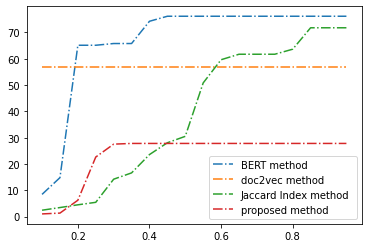

In [195]:
# importing package
import matplotlib.pyplot as plt
import numpy as np
  
# create data


y = story_len_dict_bert
x = omega_max_list
plt.plot(x, y, label = "BERT method ", linestyle="-." )

y = story_len_dict_doc2vec
plt.plot(x, y, label = "doc2vec method ", linestyle="-." )

y = story_len_dict_ji
plt.plot(x, y, label = "Jaccard Index method ", linestyle="-." )

y = story_len_dict_proposed
plt.plot(x, y, label = "proposed method ", linestyle="-." )

plt.legend()
plt.show()

In [198]:
pickle.dump(final_results_proposed, open('drive/MyDrive/temp/data_r/final_results_proposed.p', 'wb'))
pickle.dump(final_results_bert, open('drive/MyDrive/temp/data_r/final_results_bert.p', 'wb'))
pickle.dump(final_results_ji, open('drive/MyDrive/temp/data_r/final_results_ji.p', 'wb'))
pickle.dump(final_results_doc2vec, open('drive/MyDrive/temp/data_r/final_results_doc2vec.p', 'wb'))
pickle.dump(total_doc_embedding_cls, open('total_doc_embedding_cls.p', 'wb'))
pickle.dump(list_of_timestamps, open('list_of_timestamps.p', 'wb'))

In [197]:
#generate embedding for evaluation metrics
total_doc_embedding_cls = dict()
for doc in total_doc_embedding.keys():
  total_doc_embedding_cls[doc] = total_doc_embedding[doc]['cls']

Experimental results:


In [212]:
full_story_NYT_proposed_embedding = dict()
for omega in final_results_proposed.keys():
  temp_story_list = list()
  for story in final_results_proposed[omega]:
    temp_list = list()
    for doc in story:
      temp_list.append(total_doc_embedding_cls[doc])
    temp_story_list.append(temp_list)
  full_story_NYT_proposed_embedding[omega] = temp_story_list
    


In [213]:
full_story_NYT_bert_embedding = dict()
for omega in final_results_bert.keys():
  temp_story_list = list()
  for story in final_results_bert[omega]:
    temp_list = list()
    for doc in story:
      temp_list.append(total_doc_embedding_cls[doc])
    temp_story_list.append(temp_list)
  full_story_NYT_bert_embedding[omega] = temp_story_list

In [214]:
full_story_NYT_ji_embedding = dict()
for omega in final_results_ji.keys():
  temp_story_list = list()
  for story in final_results_ji[omega]:
    temp_list = list()
    for doc in story:
      temp_list.append(total_doc_embedding_cls[doc])
    temp_story_list.append(temp_list)
  full_story_NYT_ji_embedding[omega] = temp_story_list

In [215]:
full_story_NYT_doc2vec_embedding = dict()
for omega in final_results_doc2vec.keys():
  temp_story_list = list()
  for story in final_results_doc2vec[omega]:
    temp_list = list()
    for doc in story:
      temp_list.append(total_doc_embedding_cls[doc])
    temp_story_list.append(temp_list)
  full_story_NYT_doc2vec_embedding[omega] = temp_story_list

In [199]:
def disp(d_i, d_j, n, teta, i, j):
  a = np.array(d_i)
  b = np.array(d_j)
  dist = np.sqrt(np.sum(np.square(a-b))) / len(d_i)
  if dist < teta:
    return 1/(n+i-j)
  else:
    return 0

In [224]:
def final_disp(story_, teta):
  res = list()
  len_story = len(story_)
  for i in range(len_story-3):
    for j in range(i+2, len_story-1):
      res.append(disp(story_[i], story_[j], len_story, teta, i, j))
  
  return 1.0 - (sum(res)/(len_story-2 + 0.01))

In [227]:
disp_porposed = list()
disp_bert = list()
disp_ji = list()
disp_doc2vec = list()

for om in omega_max_list: 
  g_value = [final_disp(x, 0.025) for x in full_story_NYT_proposed_embedding[om]]
  disp_porposed.append(sum(g_value)/ len(g_value))
  f_value = [final_disp(x, 0.025) for x in full_story_NYT_bert_embedding[om]]
  disp_bert.append(sum(f_value)/ len(f_value))
  z_value = [final_disp(x, 0.025) for x in full_story_NYT_ji_embedding[om]]
  disp_ji.append(sum(z_value)/  len(z_value))
  a_value = [final_disp(x, 0.025) for x in full_story_NYT_doc2vec_embedding[om]]
  disp_doc2vec.append(sum(a_value)/len(a_value))




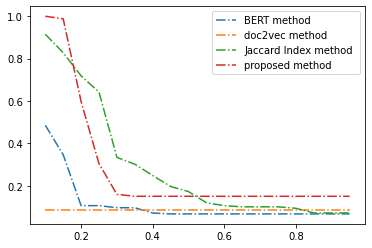

In [228]:
# importing package
import matplotlib.pyplot as plt
import numpy as np
  
# create data


y = disp_bert
x = omega_max_list
plt.plot(x, y, label = "BERT method ", linestyle="-." )

y = disp_doc2vec
plt.plot(x, y, label = "doc2vec method ", linestyle="-." )

y = disp_ji
plt.plot(x, y, label = "Jaccard Index method ", linestyle="-." )

y = disp_porposed
plt.plot(x, y, label = "proposed method ", linestyle="-." )

plt.legend()
plt.show()

In [229]:
def NS_fun(story_embed_):
  total = list()
  for x in story_embed_:
    res = list()
    for d_1, d_2 in zip(x[:-1], x[1:]):
      tmp = np.sqrt(np.sum(np.square(d_1-d_2)))
      res.append(tmp)
    total.append(sum(res)/len(res))

  return total

In [233]:
from sklearn.metrics.pairwise import cosine_similarity
def NS_cos(story_embed_):
  total = list()
  for x in story_embed_:
    res = list()
    for d_1, d_2 in zip(x[:-1], x[1:]):
      tmp = cosine_similarity([d_1],[d_2])[0][0]
      res.append(tmp)
    total.append(sum(res)/(len(res)+0.1))

  return total

In [238]:
# print(NS(full_story_NYT_proposed_embedding))
def NS(list_stories):
  res_NS = list()
  for chapter in list_stories: 
    new_vec = list()
    for x,y in zip(chapter[:-1], chapter[1:]):
      new_vec.append(np.sqrt(np.sum(np.square(x-y))))
    mean = np.mean(new_vec)
    sd = np.std(new_vec)
    avg = sum(new_vec) /(len(new_vec)+0.1)
    # tmp = (np.pi*sd) * np.exp(-0.5*((new_vec-mean)/sd)**2)
    tmp =  np.exp(-0.5*((new_vec-mean)/sd)**2)
    res_NS.append(sum(tmp)/(len(tmp)+0.1))
  return res_NS

In [ ]:
bert_NS = list()
doc2vec_NS = list()
ji_NS = list()
proposed_NS = list()
for om in omega_max_list:
  tr = np.array(NS_cos(full_story_NYT_bert_embedding[om])) / np.array(NS(full_story_NYT_bert_embedding[om]))
  bert_NS.append(sum(tr)/(len(tr)*np.sqrt(2)))
  re_ = np.array(NS_cos(full_story_NYT_doc2vec_embedding[om]))/np.array(NS(full_story_NYT_doc2vec_embedding[om]))
  doc2vec_NS.append(sum(re_) /(len(re_)*np.sqrt(2)))
  wq = np.array(NS_cos(full_story_NYT_ji_embedding[om]))/np.array(NS(full_story_NYT_ji_embedding[om]))
  ji_NS.append(sum(wq)/(len(wq)*np.sqrt(2)))
  sa = np.array(NS_cos(full_story_NYT_proposed_embedding[om]))/np.array(NS(full_story_NYT_proposed_embedding[om]))
  proposed_NS.append(sum(sa)/(len(sa)*np.sqrt(2)))


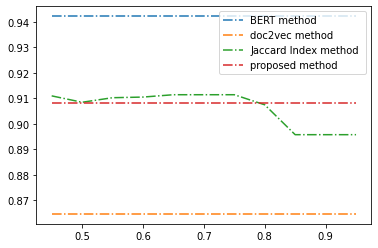

In [245]:
# importing package
import matplotlib.pyplot as plt
import numpy as np
  
# create data


y = bert_NS[7:]
x = omega_max_list[7:]
plt.plot(x, y, label = "BERT method ", linestyle="-." )

y = doc2vec_NS[7:]
plt.plot(x, y, label = "doc2vec method ", linestyle="-." )

y = ji_NS[7:]
plt.plot(x, y, label = "Jaccard Index method ", linestyle="-." )

y = proposed_NS[7:]
plt.plot(x, y, label = "proposed method ", linestyle="-." )

plt.legend()
plt.show()